In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.dummy import DummyClassifier

Data Importing and Pre-processing

In [35]:
# Load the dataset 
data = pd.read_csv('data_science_salaries.csv')
data.head()

,job_title,experience_level,employment_type,work_models,work_year,employee_residence,salary,salary_currency,salary_in_usd,company_location,company_size
0,Data Engineer,Mid-level,Full-time,Remote,2024,United States,148100,USD,148100,United States,Medium
1,Data Engineer,Mid-level,Full-time,Remote,2024,United States,98700,USD,98700,United States,Medium
2,Data Scientist,Senior-level,Full-time,Remote,2024,United States,140032,USD,140032,United States,Medium
3,Data Scientist,Senior-level,Full-time,Remote,2024,United States,100022,USD,100022,United States,Medium
4,BI Developer,Mid-level,Full-time,On-site,2024,United States,120000,USD,120000,United States,Medium


In [36]:
# Find missing data
data.isnull().sum()

job_title             0
experience_level      0
employment_type       0
work_models           0
work_year             0
employee_residence    0
salary                0
salary_currency       0
salary_in_usd         0
company_location      0
company_size          0
dtype: int64

In [37]:
# Check for duplicates and remove if any
data.duplicated().sum()

0

In [38]:
# Remove irrelevant columns
data = data[data['employee_residence'].str.contains("United States")]
data = data.drop(columns = ['salary_currency', 'employee_residence']) 

In [39]:
data.dtypes

job_title           object
experience_level    object
employment_type     object
work_models         object
work_year            int64
salary               int64
salary_in_usd        int64
company_location    object
company_size        object
dtype: object

In [40]:
# Encode categorical variables
categorical_cols = ['job_title', 'experience_level', 'employment_type', 
                    'work_models', 'company_location', 'company_size']

data_encoded = pd.get_dummies(data, columns = categorical_cols, drop_first = False)

# Check for outliers in salary_in_usd using the IQR method
q1, q3 = data['salary_in_usd'].quantile([0.25, 0.75])
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Remove rows with outliers in salary_in_usd
data_cleaned = data[(data['salary_in_usd'] >= lower_bound) & 
                    (data['salary_in_usd'] <= upper_bound)]

In [41]:
# Display summary of cleaned data
print(data_cleaned.info())
print(data_cleaned.head())

<class 'pandas.core.frame.DataFrame'>
Index: 5204 entries, 0 to 6556
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   job_title         5204 non-null   object
 1   experience_level  5204 non-null   object
 2   employment_type   5204 non-null   object
 3   work_models       5204 non-null   object
 4   work_year         5204 non-null   int64 
 5   salary            5204 non-null   int64 
 6   salary_in_usd     5204 non-null   int64 
 7   company_location  5204 non-null   object
 8   company_size      5204 non-null   object
dtypes: int64(3), object(6)
memory usage: 406.6+ KB
None
        job_title experience_level employment_type work_models  work_year  \
0   Data Engineer        Mid-level       Full-time      Remote       2024   
1   Data Engineer        Mid-level       Full-time      Remote       2024   
2  Data Scientist     Senior-level       Full-time      Remote       2024   
3  Data Scientist     Senior

In [42]:
data_cleaned.describe()

,work_year,salary,salary_in_usd
count,5204.000000,5204.000000,5204.000000
mean,2022.888163,153211.435050,153220.955419
std,0.590284,57568.049715,57552.569690
min,2020.000000,24000.000000,24000.000000
25%,2023.000000,110000.000000,110000.000000
50%,2023.000000,147000.000000,147000.000000
75%,2023.000000,190000.000000,190000.000000
max,2024.000000,318300.000000,318300.000000


Data Analysis and Visualization

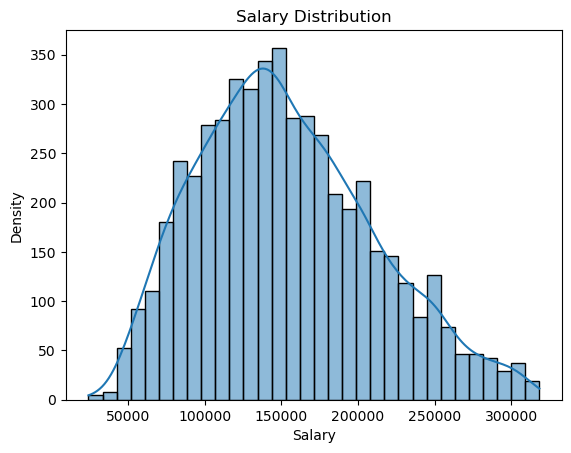

In [43]:
sns.histplot(data_cleaned['salary_in_usd'], kde = True)
plt.xlabel('Salary')
plt.ylabel('Density')
plt.title('Salary Distribution')
plt.show()

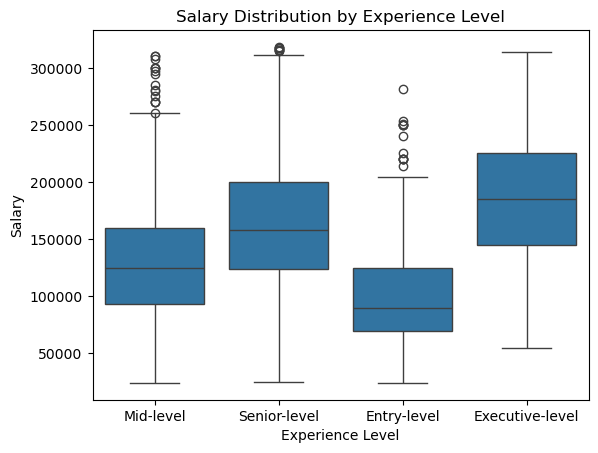

In [44]:
# Salary distribution across experience level
sns.boxplot(x = 'experience_level', y = 'salary_in_usd', data = data_cleaned)
plt.xlabel('Experience Level')
plt.ylabel('Salary')
plt.title('Salary Distribution by Experience Level')
plt.show()

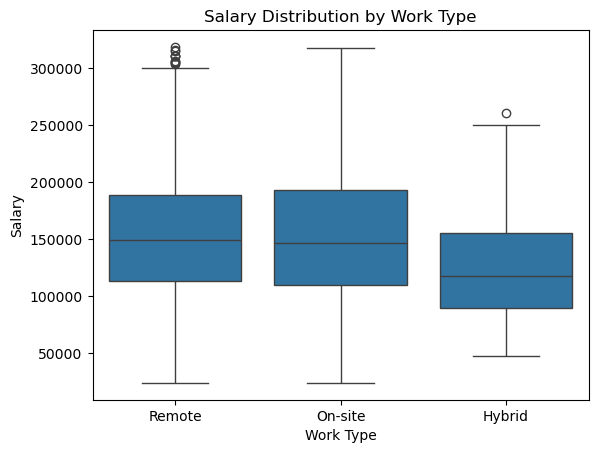

In [45]:
# Salary distribution across work type
sns.boxplot(x = 'work_models', y = 'salary_in_usd', data = data_cleaned)
plt.xlabel('Work Type')
plt.ylabel('Salary')
plt.title('Salary Distribution by Work Type')
plt.show()

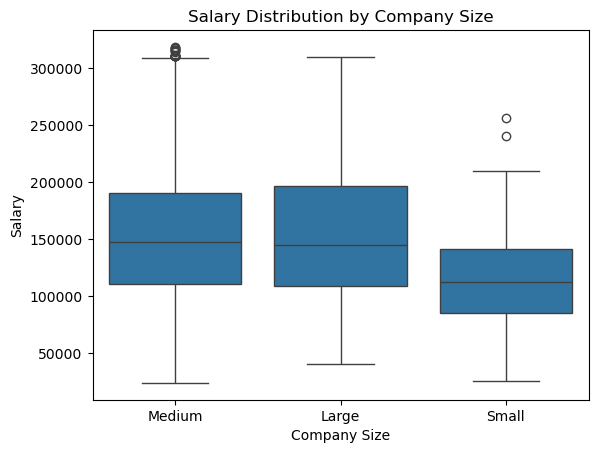

In [46]:
# Salary distribution across company size
sns.boxplot(x = 'company_size', y = 'salary_in_usd', data = data_cleaned)
plt.xlabel('Company Size')
plt.ylabel('Salary')
plt.title('Salary Distribution by Company Size')
plt.show()

In [47]:
interaction_effects  =  data_cleaned.groupby(['work_models', 'company_size'])['salary_in_usd'].mean().reset_index()

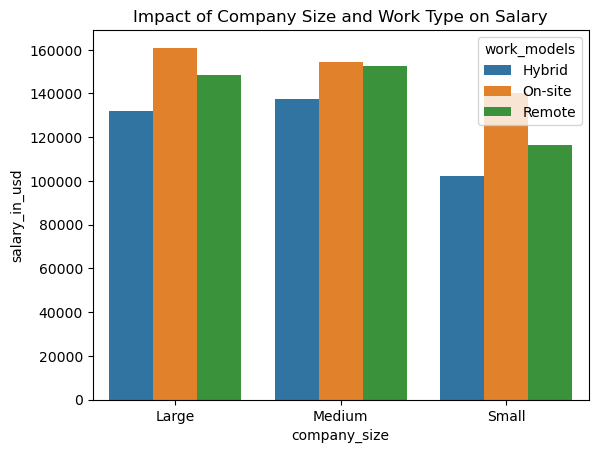

In [48]:
# Bar plot to visualize company size and work type on salary
sns.barplot(data = interaction_effects, x = 'company_size', y = 'salary_in_usd', hue = 'work_models')
plt.title('Impact of Company Size and Work Type on Salary')
plt.show()

In [49]:
interaction_effects2 = data_cleaned.groupby(['work_models', 'experience_level'])['salary_in_usd'].mean().reset_index()

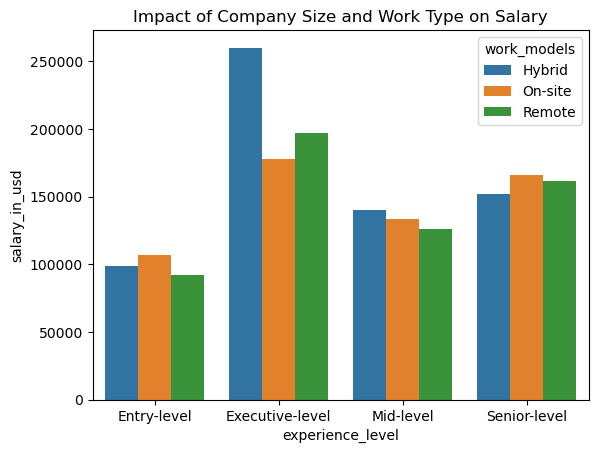

In [50]:
# Bar plot to visualize experience level and work type on salary
sns.barplot(data = interaction_effects2, x = 'experience_level', y = 'salary_in_usd', hue = 'work_models')
plt.title('Impact of Company Size and Work Type on Salary')
plt.show()

In [51]:
# Median of salary
salary_median = data_cleaned['salary_in_usd'].median()

In [52]:
# Convert 'salary_in_usd' to binary
data_cleaned['salary_binary'] = data_cleaned['salary_in_usd'].apply(lambda x: 'High' if x > salary_median else 'Low')

/var/folders/6j/qtnqw_nn0bj948l89lgcc38m0000gn/T/ipykernel_17069/884209481.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['salary_binary'] = data_cleaned['salary_in_usd'].apply(lambda x: 'High' if x > salary_median else 'Low')


<Axes: xlabel='company_size'>

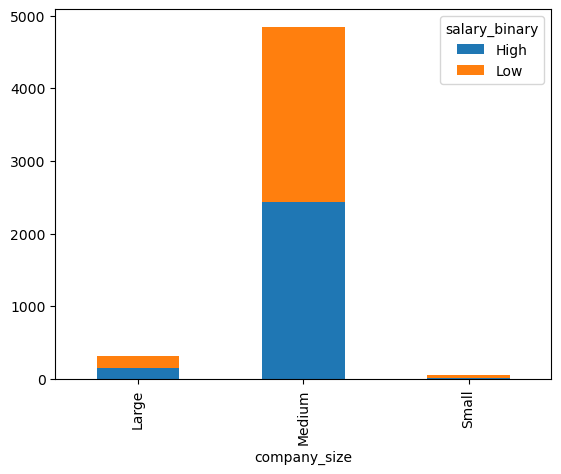

In [53]:
# Bar graph of company_size by salary
company_salary = pd.crosstab(data_cleaned['company_size'], data_cleaned['salary_binary'])
company_salary.plot(kind = 'bar', stacked = True)

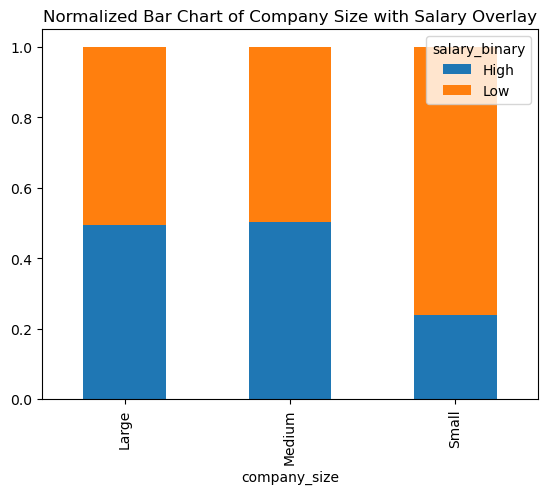

In [54]:
# Normalized
company_salary_norm = company_salary.div(company_salary.sum(1), axis = 0)
company_salary_norm.plot(kind = 'bar', stacked = True)
plt.title('Normalized Bar Chart of Company Size with Salary Overlay')
plt.show()

<Axes: xlabel='experience_level'>

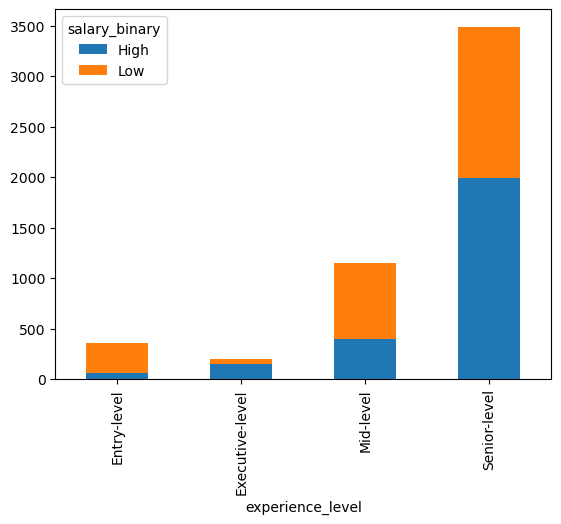

In [55]:
# Bar graph of experience_level by salary
experience_salary = pd.crosstab(data_cleaned['experience_level'], data_cleaned['salary_binary'])
experience_salary.plot(kind = 'bar', stacked = True)

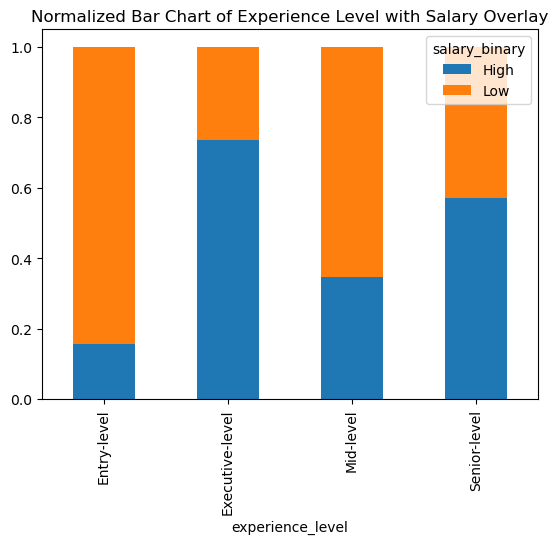

In [56]:
# Normalized
experience_salary_norm = experience_salary.div(experience_salary.sum(1), axis = 0)
experience_salary_norm.plot(kind = 'bar', stacked = True)
plt.title('Normalized Bar Chart of Experience Level with Salary Overlay')
plt.show()

<Axes: xlabel='work_models'>

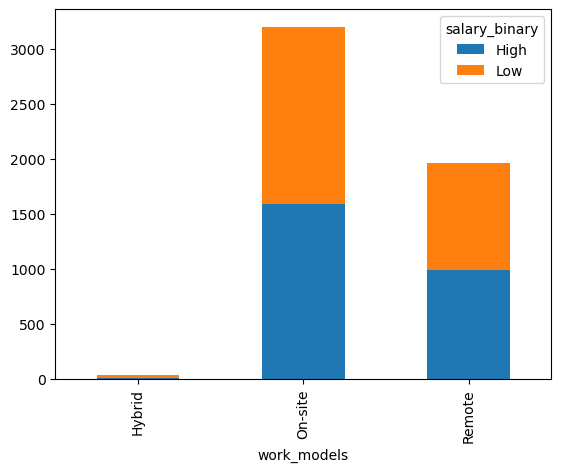

In [57]:
# Bar graph of work_models by salary
work_salary = pd.crosstab(data_cleaned['work_models'], data_cleaned['salary_binary'])
work_salary.plot(kind = 'bar', stacked = True)

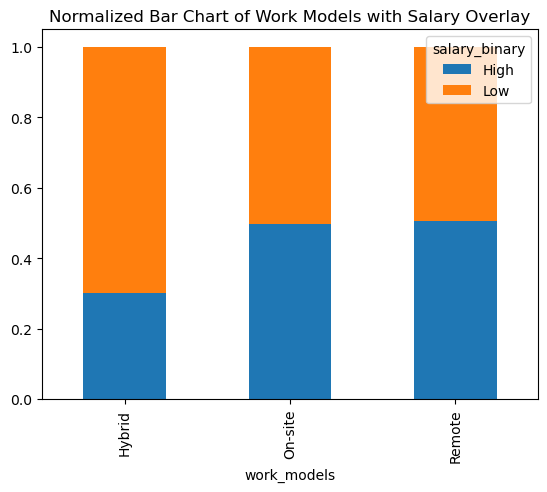

In [58]:
# Normalized
work_salary_norm = work_salary.div(work_salary.sum(1), axis = 0)
work_salary_norm.plot(kind = 'bar', stacked = True)
plt.title('Normalized Bar Chart of Work Models with Salary Overlay')
plt.show()

Split dataset to training and test

In [59]:
# Partition dataset 
data_train, data_test = train_test_split(data_cleaned, test_size = 0.2, random_state = 7)

In [60]:
# Confirm split proportions
split_proportions = pd.DataFrame({'Dataset': ['Training', 'Test'],
                                  'Proportion': [len(data_train) / len(data_cleaned), len(data_test) / len(data_cleaned)]
})

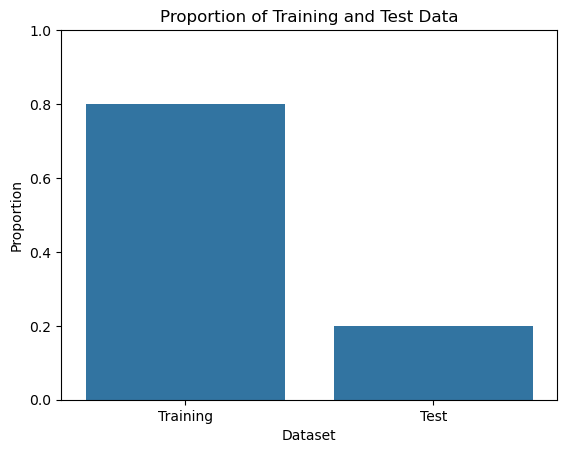

In [61]:
sns.barplot(x = 'Dataset', y = 'Proportion', data = split_proportions)

plt.title('Proportion of Training and Test Data')
plt.ylabel('Proportion')
plt.xlabel('Dataset')
plt.ylim(0, 1)
plt.show()

In [62]:
# Check if rebalance is needed
data_train['salary_binary'].value_counts()

salary_binary
High    2085
Low     2078
Name: count, dtype: int64

In [63]:
# Prep data for modeling
y_train = data_train[['salary_binary']]
y_test = data_test[['salary_binary']]
data_train = pd.get_dummies(data_train, 
                            prefix = None, 
                            columns = ['company_size', 'experience_level','work_models'], 
                            drop_first = False)
data_test = pd.get_dummies(data_test, 
                           prefix = None, 
                           columns = ['company_size', 'experience_level','work_models'], 
                           drop_first = False)

In [64]:
data_train.columns

Index(['job_title', 'employment_type', 'work_year', 'salary', 'salary_in_usd',
       'company_location', 'salary_binary', 'company_size_Large',
       'company_size_Medium', 'company_size_Small',
       'experience_level_Entry-level', 'experience_level_Executive-level',
       'experience_level_Mid-level', 'experience_level_Senior-level',
       'work_models_Hybrid', 'work_models_On-site', 'work_models_Remote'],
      dtype='object')

In [65]:
X_train = data_train[['company_size_Large', 'company_size_Medium', 
                      'company_size_Small', 'experience_level_Entry-level', 
                      'experience_level_Executive-level', 
                      'experience_level_Mid-level', 'experience_level_Senior-level', 
                      'work_models_Hybrid', 'work_models_On-site', 
                      'work_models_Remote']]
X_test = data_test[['company_size_Large', 'company_size_Medium', 
                    'company_size_Small', 'experience_level_Entry-level', 
                    'experience_level_Executive-level', 'experience_level_Mid-level', 
                    'experience_level_Senior-level', 'work_models_Hybrid', 
                    'work_models_On-site', 'work_models_Remote']]

In [66]:
X_names = ["company_size_Large", "company_size_Medium", 
           "company_size_Small", "experience_level_Entry-level", 
           "experience_level_Executive-level", "experience_level_Mid-level", 
           "experience_level_Senior-level", "work_models_Hybrid", 
           "work_models_On-site", "work_models_Remote"]
y_names = ["High", "Low"]

Random Forest

In [67]:
rf = RandomForestClassifier(n_estimators = 100, criterion = "gini").fit(X_train, y_train)

/var/folders/6j/qtnqw_nn0bj948l89lgcc38m0000gn/T/ipykernel_17069/3314980583.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestClassifier(n_estimators = 100, criterion = "gini").fit(X_train, y_train)


In [68]:
y_pred_rf = rf.predict(X_test)

In [69]:
cm = confusion_matrix(y_test, y_pred_rf)
cm

array([[421,  91],
       [325, 204]])

In [70]:
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))


Random Forest Accuracy: 0.6003842459173871
Classification Report:
               precision    recall  f1-score   support

        High       0.56      0.82      0.67       512
         Low       0.69      0.39      0.50       529

    accuracy                           0.60      1041
   macro avg       0.63      0.60      0.58      1041
weighted avg       0.63      0.60      0.58      1041



In [71]:
TN = cm[1][1]
FP = cm[1][0]
FN = cm[0][1]
TP = cm[0][0]
TAN = TN + FP
TAP = FN + TP
TPN = TN + FN
TPP = FP + TP
GT = TN + FP + FN + TP

Accuracy = (TN + TP)/GT
ErrorRate = 1 - Accuracy
Sensitivity = TP/TAP 
Recall = Sensitivity
Specificity = TN/TAN
Precision = TP/TPP
F1 = (2 * Precision * Recall)/(Precision + Recall)
F2 = (5 * Precision * Recall)/((4 * Precision) + Recall)
F0_5 = (1.25 * Precision * Recall)/((.25 * Precision) + Recall)

In [72]:
print("Random Forest Accuracy:", Accuracy)
print("Random Forest Error Rate:", ErrorRate)
print("Random Forest Sensitivity:", Recall)
print("Random Forest Specificity:", Specificity)
print("Random Forest Precision:", Precision)
print("Random Forest F1:", F1)
print("Random Forest F2:", F2)
print("Random Forest F0.5:", F0_5)

Random Forest Accuracy: 0.6003842459173871
Random Forest Error Rate: 0.39961575408261285
Random Forest Sensitivity: 0.822265625
Random Forest Specificity: 0.3856332703213611
Random Forest Precision: 0.564343163538874
Random Forest F1: 0.6693163751987282
Random Forest F2: 0.7534001431639228
Random Forest F0.5: 0.6021167048054921


Logistic Regression

In [73]:
log_reg = LogisticRegression().fit(X_train, y_train.values.ravel())

In [74]:
y_pred_logreg = log_reg.predict(X_test)

In [75]:
cm_logreg = confusion_matrix(y_test, y_pred_logreg)
cm_logreg

array([[421,  91],
       [319, 210]])

In [76]:
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_logreg))
print("Classification Report:\n", classification_report(y_test, y_pred_logreg))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_logreg))

Logistic Regression Accuracy: 0.6061479346781941
Classification Report:
               precision    recall  f1-score   support

        High       0.57      0.82      0.67       512
         Low       0.70      0.40      0.51       529

    accuracy                           0.61      1041
   macro avg       0.63      0.61      0.59      1041
weighted avg       0.63      0.61      0.59      1041

Confusion Matrix:
 [[421  91]
 [319 210]]


In [77]:
TN = cm_logreg[1][1]
FP = cm_logreg[1][0]
FN = cm_logreg[0][1]
TP = cm_logreg[0][0]
TAN = TN + FP
TAP = FN + TP
TPN = TN + FN
TPP = FP + TP
GT = TN + FP + FN + TP

Accuracy = (TN + TP)/GT
ErrorRate = 1 - Accuracy
Sensitivity = TP/TAP 
Recall = Sensitivity
Specificity = TN/TAN
Precision = TP/TPP
F1 = (2 * Precision * Recall)/(Precision + Recall)
F2 = (5 * Precision * Recall)/((4 * Precision) + Recall)
F0_5 = (1.25 * Precision * Recall)/((.25 * Precision) + Recall)

In [78]:
print("Logistic Regression Accuracy:", Accuracy)
print("Logistic Regression Error Rate:", ErrorRate)
print("Logistic Regression Sensitivity:", Recall)
print("Logistic Regression Specificity:", Specificity)
print("Logistic Regression Precision:", Precision)
print("Logistic Regression F1:", F1)
print("Logistic Regression F2:", F2)
print("Logistic Regression F0.5:", F0_5)

Logistic Regression Accuracy: 0.6061479346781941
Logistic Regression Error Rate: 0.39385206532180594
Logistic Regression Sensitivity: 0.822265625
Logistic Regression Specificity: 0.39697542533081287
Logistic Regression Precision: 0.5689189189189189
Logistic Regression F1: 0.6725239616613419
Logistic Regression F2: 0.7550215208034432
Logistic Regression F0.5: 0.606278801843318


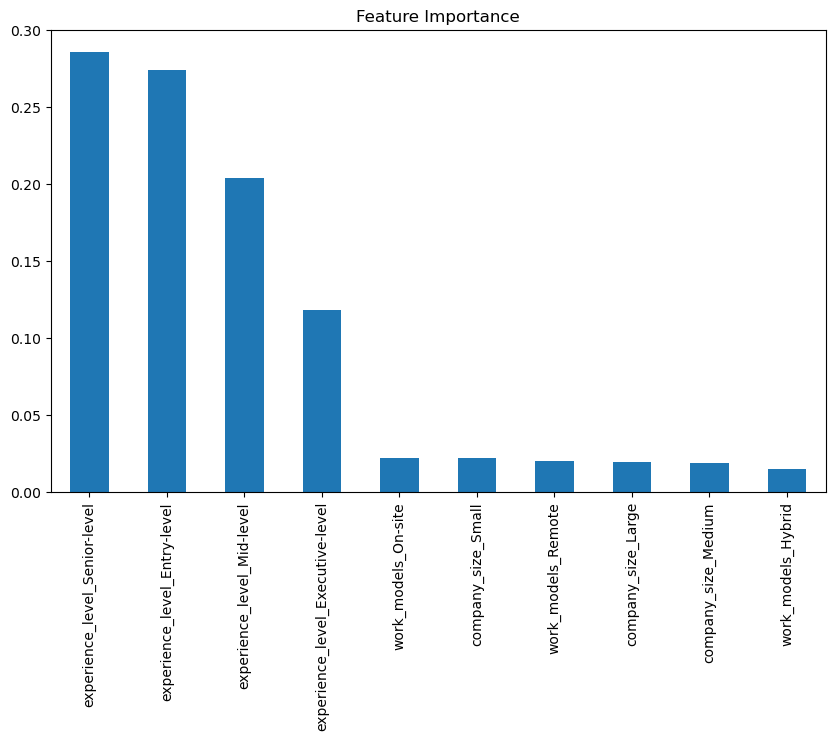

In [79]:
# Analyze feature importance
importance = pd.Series(rf.feature_importances_, index = X_train.columns)
importance.sort_values(ascending = False).plot(kind = 'bar', figsize = (10, 6))
plt.title('Feature Importance')
plt.show()

CART

In [80]:
cart = DecisionTreeClassifier(criterion = "gini", max_leaf_nodes = 5).fit(X_train, y_train)

[Text(0.5555555555555556, 0.875, 'experience_level_Senior-level <= 0.5\ngini = 0.5\nsamples = 4163\nvalue = [2085, 2078]\nclass = High'),
 Text(0.3333333333333333, 0.625, 'experience_level_Executive-level <= 0.5\ngini = 0.457\nsamples = 1377\nvalue = [486, 891]\nclass = Low'),
 Text(0.2222222222222222, 0.375, 'experience_level_Entry-level <= 0.5\ngini = 0.421\nsamples = 1217\nvalue = [367, 850]\nclass = Low'),
 Text(0.1111111111111111, 0.125, 'gini = 0.452\nsamples = 932\nvalue = [321, 611]\nclass = Low'),
 Text(0.3333333333333333, 0.125, 'gini = 0.271\nsamples = 285\nvalue = [46, 239]\nclass = Low'),
 Text(0.4444444444444444, 0.375, 'gini = 0.381\nsamples = 160\nvalue = [119, 41]\nclass = High'),
 Text(0.7777777777777778, 0.625, 'company_size_Small <= 0.5\ngini = 0.489\nsamples = 2786\nvalue = [1599, 1187]\nclass = High'),
 Text(0.6666666666666666, 0.375, 'gini = 0.489\nsamples = 2775\nvalue = [1596, 1179]\nclass = High'),
 Text(0.8888888888888888, 0.375, 'gini = 0.397\nsamples = 11\n

<Figure size 640x480 with 0 Axes>

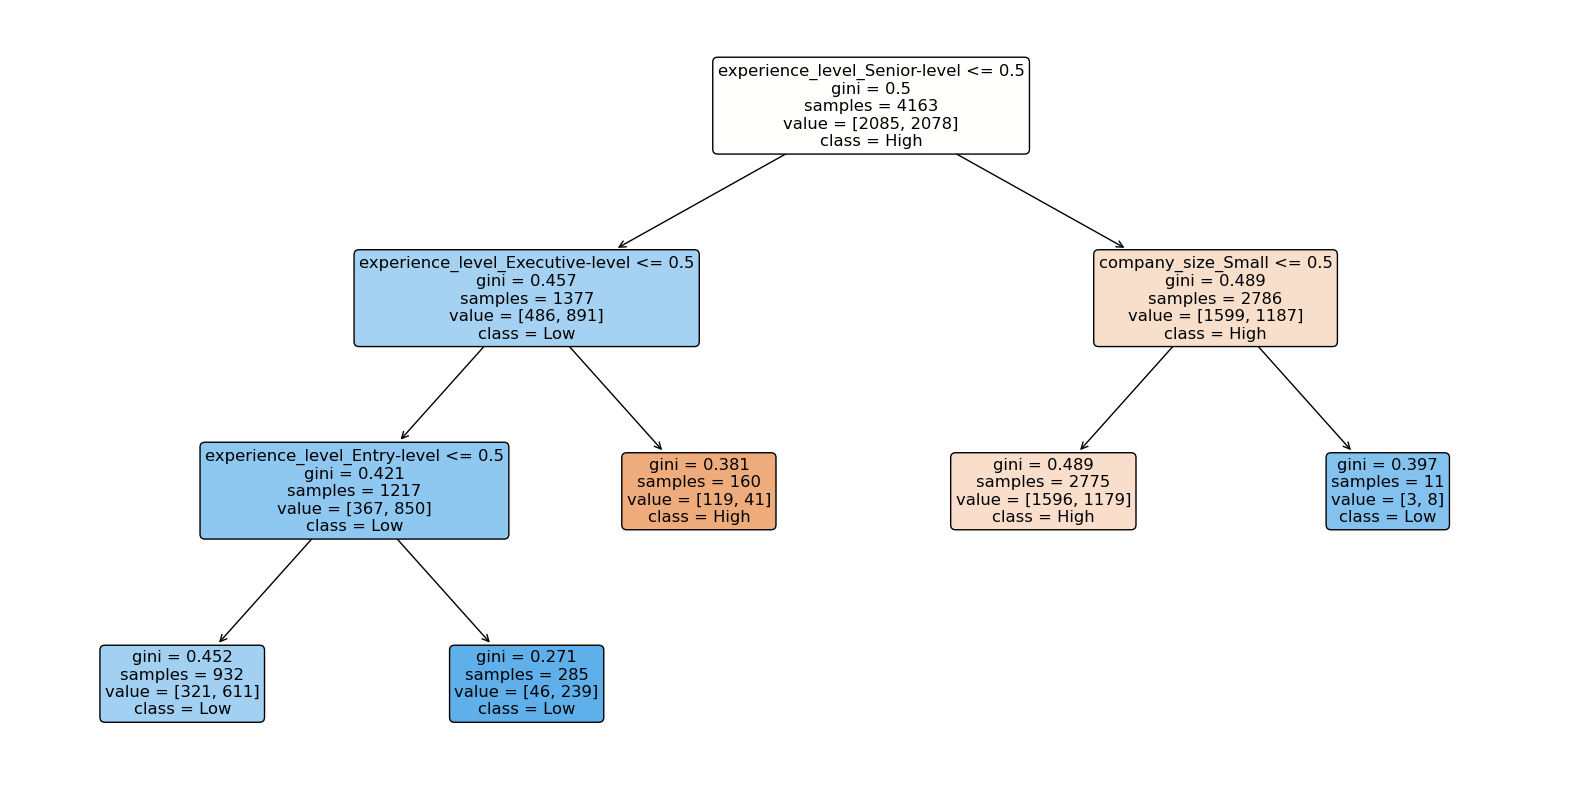

In [81]:
plt.figure()
plt.figure(figsize = (20,10))
plot_tree(cart,
          feature_names = X_names,
          class_names = y_names,
          filled = True,
          rounded = True)

In [82]:
y_pred_cart = cart.predict(X_test)
y_pred_cart

array(['High', 'High', 'Low', ..., 'High', 'High', 'High'], dtype=object)

In [83]:
cm_cart = confusion_matrix(y_test, y_pred_cart)
cm_cart

array([[421,  91],
       [319, 210]])

In [84]:
print("CART Accuracy:", accuracy_score(y_test, y_pred_cart))
print("Classification Report:\n", classification_report(y_test, y_pred_cart))

CART Accuracy: 0.6061479346781941
Classification Report:
               precision    recall  f1-score   support

        High       0.57      0.82      0.67       512
         Low       0.70      0.40      0.51       529

    accuracy                           0.61      1041
   macro avg       0.63      0.61      0.59      1041
weighted avg       0.63      0.61      0.59      1041



In [85]:
TN = cm_cart[1][1]
FP = cm_cart[1][0]
FN = cm_cart[0][1]
TP = cm_cart[0][0]
TAN = TN + FP
TAP = FN + TP
TPN = TN + FN
TPP = FP + TP
GT = TN + FP + FN + TP

Accuracy = (TN + TP)/GT
ErrorRate = 1 - Accuracy
Sensitivity = TP/TAP 
Recall = Sensitivity
Specificity = TN/TAN
Precision = TP/TPP
F1 = (2 * Precision * Recall)/(Precision + Recall)
F2 = (5 * Precision * Recall)/((4 * Precision) + Recall)
F0_5 = (1.25 * Precision * Recall)/((.25 * Precision) + Recall)

In [86]:
print("CART Accuracy:", Accuracy)
print("CART Error Rate:", ErrorRate)
print("CART Sensitivity:", Recall)
print("CART Specificity:", Specificity)
print("CART Precision:", Precision)
print("CART F1:", F1)
print("CART F2:", F2)
print("CART F0.5:", F0_5)

CART Accuracy: 0.6061479346781941
CART Error Rate: 0.39385206532180594
CART Sensitivity: 0.822265625
CART Specificity: 0.39697542533081287
CART Precision: 0.5689189189189189
CART F1: 0.6725239616613419
CART F2: 0.7550215208034432
CART F0.5: 0.606278801843318


C5.0 Model

In [87]:
c50 = DecisionTreeClassifier(criterion = "entropy", max_leaf_nodes = 5).fit(X_train, y_train)

[Text(0.7142857142857143, 0.9, 'experience_level_Senior-level <= 0.5\nentropy = 1.0\nsamples = 4163\nvalue = [2085, 2078]\nclass = High'),
 Text(0.5714285714285714, 0.7, 'experience_level_Executive-level <= 0.5\nentropy = 0.937\nsamples = 1377\nvalue = [486, 891]\nclass = Low'),
 Text(0.42857142857142855, 0.5, 'experience_level_Mid-level <= 0.5\nentropy = 0.883\nsamples = 1217\nvalue = [367, 850]\nclass = Low'),
 Text(0.2857142857142857, 0.3, 'company_size_Small <= 0.5\nentropy = 0.638\nsamples = 285\nvalue = [46, 239]\nclass = Low'),
 Text(0.14285714285714285, 0.1, 'entropy = 0.656\nsamples = 272\nvalue = [46, 226]\nclass = Low'),
 Text(0.42857142857142855, 0.1, 'entropy = 0.0\nsamples = 13\nvalue = [0, 13]\nclass = Low'),
 Text(0.5714285714285714, 0.3, 'entropy = 0.929\nsamples = 932\nvalue = [321, 611]\nclass = Low'),
 Text(0.7142857142857143, 0.5, 'entropy = 0.821\nsamples = 160\nvalue = [119, 41]\nclass = High'),
 Text(0.8571428571428571, 0.7, 'entropy = 0.984\nsamples = 2786\nval

<Figure size 640x480 with 0 Axes>

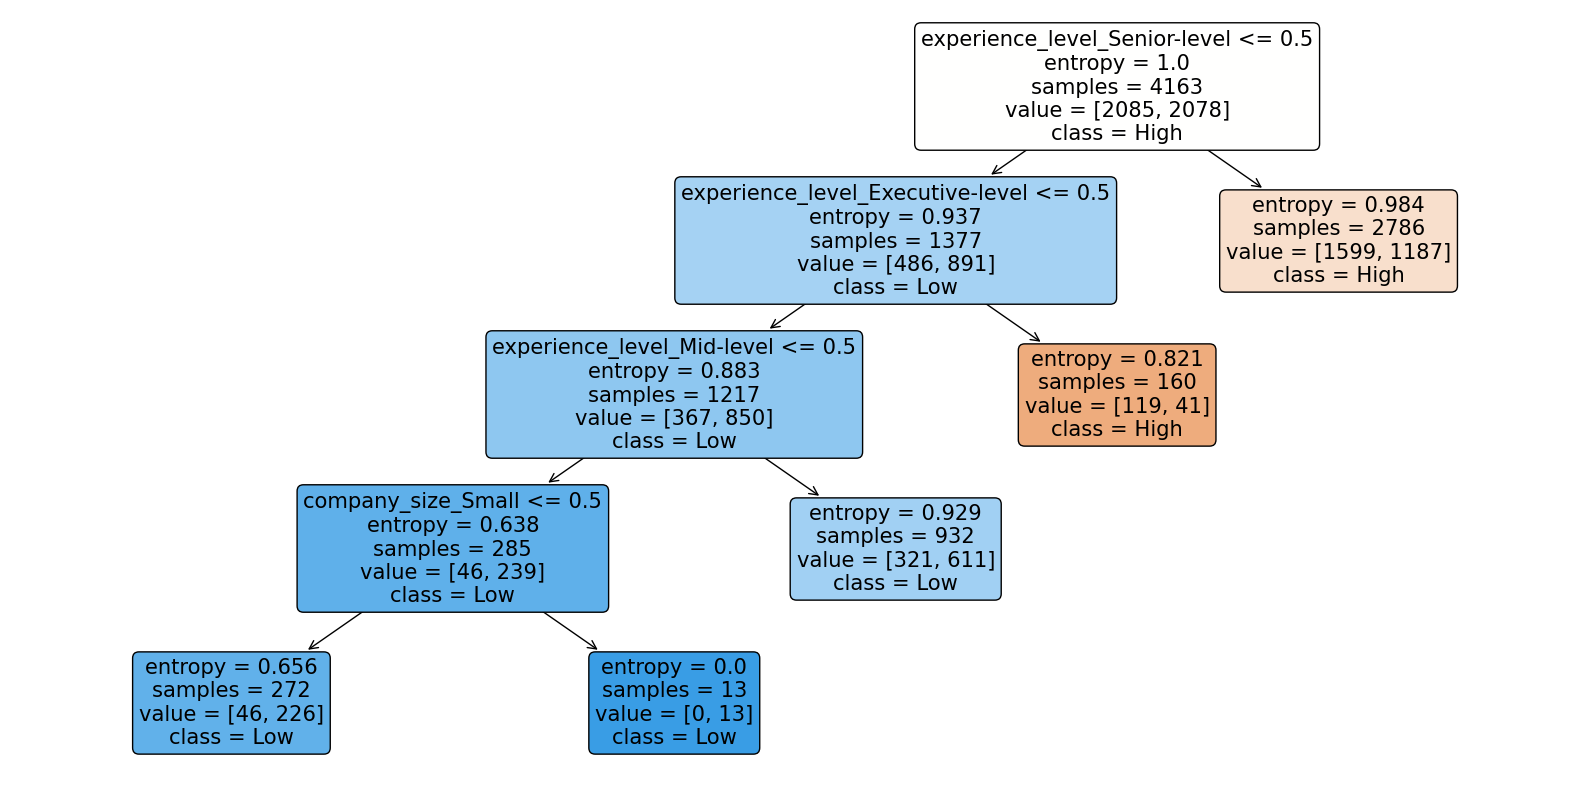

In [88]:
plt.figure()
plt.figure(figsize = (20,10))
plot_tree(c50,
          feature_names = X_names,
          class_names = y_names,
          filled = True,
          rounded = True)

In [89]:
y_pred_c50 = c50.predict(X_test)

In [90]:
cm_c50 = confusion_matrix(y_test, y_pred_c50)
cm_c50

array([[423,  89],
       [321, 208]])

In [91]:
print("C5.0 Accuracy:", accuracy_score(y_test, y_pred_c50))
print("Classification Report:\n", classification_report(y_test, y_pred_c50))

C5.0 Accuracy: 0.6061479346781941
Classification Report:
               precision    recall  f1-score   support

        High       0.57      0.83      0.67       512
         Low       0.70      0.39      0.50       529

    accuracy                           0.61      1041
   macro avg       0.63      0.61      0.59      1041
weighted avg       0.64      0.61      0.59      1041



In [92]:
TN = cm_c50[1][1]
FP = cm_c50[1][0]
FN = cm_c50[0][1]
TP = cm_c50[0][0]
TAN = TN + FP
TAP = FN + TP
TPN = TN + FN
TPP = FP + TP
GT = TN + FP + FN + TP

Accuracy = (TN + TP)/GT
ErrorRate = 1 - Accuracy
Sensitivity = TP/TAP 
Recall = Sensitivity
Specificity = TN/TAN
Precision = TP/TPP
F1 = (2 * Precision * Recall)/(Precision + Recall)
F2 = (5 * Precision * Recall)/((4 * Precision) + Recall)
F0_5 = (1.25 * Precision * Recall)/((.25 * Precision) + Recall)

In [93]:
print("C5.0 Accuracy:", Accuracy)
print("C5.0 Error Rate:", ErrorRate)
print("C5.0 Sensitivity:", Recall)
print("C5.0 Specificity:", Specificity)
print("C5.0 Precision:", Precision)
print("C5.0 F1:", F1)
print("C5.0 F2:", F2)
print("C5.0 F0.5:", F0_5)

C5.0 Accuracy: 0.6061479346781941
C5.0 Error Rate: 0.39385206532180594
C5.0 Sensitivity: 0.826171875
C5.0 Specificity: 0.3931947069943289
C5.0 Precision: 0.5685483870967742
C5.0 F1: 0.6735668789808917
C5.0 F2: 0.7575214899713466
C5.0 F0.5: 0.6063646788990825


Naive Bayes

In [94]:
nb = MultinomialNB().fit(X_train, y_train.values.ravel())

In [95]:
y_pred_nb = nb.predict(X_test)

In [96]:
cm_nb = confusion_matrix(y_test, y_pred_nb)
cm_nb

array([[418,  94],
       [318, 211]])

In [97]:
print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Classification Report:\n", classification_report(y_test, y_pred_nb))

Naive Bayes Accuracy: 0.6042267050912584
Classification Report:
               precision    recall  f1-score   support

        High       0.57      0.82      0.67       512
         Low       0.69      0.40      0.51       529

    accuracy                           0.60      1041
   macro avg       0.63      0.61      0.59      1041
weighted avg       0.63      0.60      0.59      1041



In [98]:
TN = cm_nb[1][1]
FP = cm_nb[1][0]
FN = cm_nb[0][1]
TP = cm_nb[0][0]
TAN = TN + FP
TAP = FN + TP
TPN = TN + FN
TPP = FP + TP
GT = TN + FP + FN + TP

Accuracy = (TN + TP)/GT
ErrorRate = 1 - Accuracy
Sensitivity = TP/TAP 
Recall = Sensitivity
Specificity = TN/TAN
Precision = TP/TPP
F1 = (2 * Precision * Recall)/(Precision + Recall)
F2 = (5 * Precision * Recall)/((4 * Precision) + Recall)
F0_5 = (1.25 * Precision * Recall)/((.25 * Precision) + Recall)

In [99]:
print("NB Accuracy:", Accuracy)
print("NB Error Rate:", ErrorRate)
print("NB Sensitivity:", Recall)
print("NB Specificity:", Specificity)
print("NB Precision:", Precision)
print("NB F1:", F1)
print("NB F2:", F2)
print("NB F0.5:", F0_5)

NB Accuracy: 0.6042267050912584
NB Error Rate: 0.3957732949087416
NB Sensitivity: 0.81640625
NB Specificity: 0.3988657844990548
NB Precision: 0.5679347826086957
NB F1: 0.6698717948717948
NB F2: 0.7507183908045977
NB F0.5: 0.6047453703703703


Baseline Model

In [100]:
baseline = DummyClassifier(strategy = 'uniform', random_state = 7).fit(X_train, y_train.values.ravel())

In [101]:
y_pred_baseline = baseline.predict(X_test)

In [102]:
cm_baseline = confusion_matrix(y_test, y_pred_baseline)
cm_baseline

array([[250, 262],
       [276, 253]])

In [103]:
TN = cm_baseline[1][1]
FP = cm_baseline[1][0]
FN = cm_baseline[0][1]
TP = cm_baseline[0][0]
TAN = TN + FP
TAP = FN + TP
TPN = TN + FN
TPP = FP + TP
GT = TN + FP + FN + TP

Accuracy = (TN + TP)/GT
ErrorRate = 1 - Accuracy
Sensitivity = TP/TAP 
Recall = Sensitivity
Specificity = TN/TAN
Precision = TP/TPP
F1 = (2 * Precision * Recall)/(Precision + Recall)
F2 = (5 * Precision * Recall)/((4 * Precision) + Recall)
F0_5 = (1.25 * Precision * Recall)/((.25 * Precision) + Recall)

In [104]:
print("Baseline Accuracy:", Accuracy)
print("Baseline Error Rate:", ErrorRate)
print("Baseline Sensitivity:", Recall)
print("Baseline Specificity:", Specificity)
print("Baseline Precision:", Precision)
print("Baseline F1:", F1)
print("Baseline F2:", F2)
print("Baseline F0.5:", F0_5)

Baseline Accuracy: 0.48318924111431316
Baseline Error Rate: 0.5168107588856868
Baseline Sensitivity: 0.48828125
Baseline Specificity: 0.4782608695652174
Baseline Precision: 0.4752851711026616
Baseline F1: 0.4816955684007707
Baseline F2: 0.48562548562548563
Baseline F0.5: 0.47782874617737
